In [338]:
# Installing all libraries and packages 
!pip3 install requests
!pip3 install pandas
!pip3 install SQLAlchemy
!pip3 install mysql-connector-python
!pip3 install html5lib
!pip3 install bs4
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from statistics import mean
from bs4 import BeautifulSoup
import requests
import json
from urllib.parse import quote 
import mysql.connector
import sqlalchemy
from sqlalchemy.engine import create_engine
import pandas as pd

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3

In [339]:

# This data is taken from YELP Fusion documentation
#Business Search      URL -- 'https://api.yelp.com/v3/businesses/search'
#Business Match       URL -- 'https://api.yelp.com/v3/businesses/matches'
#Phone Search         URL -- 'https://api.yelp.com/v3/businesses/search/phone'
#Business Details     URL -- 'https://api.yelp.com/v3/businesses/{id}'
#Business Reviews     URL -- 'https://api.yelp.com/v3/businesses/{id}/reviews'

# Define my API Key, My Endpoint, and My Header
API_KEY = 'WQXg8c6_o1fwxvnjJZA6Yc45BIYpG2VfeP4St7evIYNuLJnGwH6Z_vDLn7EZ1pOeqCJ8Df6tu-Px_GJTOHQFHLSdVL6pLWc1Wo1jwEVOyDVE46Pq6TtzATqEdbCKY3Yx'
ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
HEADERS = {'Authorization': 'bearer %s' % API_KEY}

# Define my parameters of the search
# BUSINESS SEARCH PARAMETERS - EXAMPLE


# BUSINESS MATCH PARAMETERS - EXAMPLE
#PARAMETERS = {'name': 'Peets Coffee & Tea',
#              'address1': '7845 Highland Village Pl',
#              'city': 'San Diego',
#              'state': 'CA',
#              'country': 'US'}


In [390]:
# Make a request to the Yelp API
# API Fusion Limit
PARAMETERS = {'radius': 40000,
             'location': 'Boston',
             'limit': 50
             }

response = requests.get(url = ENDPOINT,
                        params = PARAMETERS,
                        headers = HEADERS)
# We get a response from the API 
business_data = response.json()['businesses']
b_info = []
cat_info = []
for b in business_data:
    # Append the data need from the json in the list 
    b_info.append((b['id'], b['name'], b['location']['address1'], b['location']['city'], b['location']['state'], b['location']['zip_code'], b['rating'], b['review_count'] ,not b['is_closed']))
    
    for i in b['categories']:
        cat_info.append((b['id'],i['title']))

In [393]:
# Creating business and category dataFrame
df_b = pd.DataFrame(b_info, columns =['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'stars', 'review_count','is_open'])
df_cat = pd.DataFrame(cat_info, columns =['business_id','categories'])


In [378]:
# Get list of business_ids from Business Dataframe
b_id_list = df_b["business_id"].tolist()
# Request 3 latest reviews for the businesses in dataframe
review_info = []
user_ids = []
for l in b_id_list:
    response = requests.get(url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(l), headers = HEADERS)
    review_data = response.json()['reviews']
    for b in review_data:
        user_ids.append((b['user']['id']))
        review_info.append((b['id'], b['user']['id'], l, b['rating'],b['text'], b['time_created']))

In [379]:
# Web Scrapping user information using beautiful soup
user_info = []
for i in user_ids:
    URL = 'https://www.yelp.com/user_details?userid={}'.format(str(i))
    r = requests.get(URL)
    soup = BeautifulSoup(r.content, 'html5lib') # If this line causes an error, run 'pip install html5lib' or install html5lib
    u_name = soup.find('div', class_="user-profile_info arrange_unit").find("h1", recursive=False).text
    u_review_count = soup.find('li', class_="review-count").find("strong", recursive=False).text
    #convert date into proper datetime format
    t_yelp_since = soup.find('div', class_="user-details-overview_sidebar").find_all("p")[1].text
    u_yelp_since = datetime.strptime("1 {}".format(t_yelp_since), '%d %B %Y').strftime('%Y-%m-%d')
    #since avg stars isn't specifically given we approximate this info by taking avg of rating of fist page
    u_star=[]
    u_a_list = soup.find_all('div', "i-stars")
    for u in u_a_list:
        u_star.append(float(u["title"][0:3]))
    # This information is not directly given on the web page so we approximate this information 
    u_avg_stars = round(sum(u_star)/len(u_star),2)
    user_info.append((i,u_name,u_review_count,u_yelp_since,u_avg_stars))
    


In [380]:
# Creating User and Review Dataframe
df_user = pd.DataFrame(user_info,columns=['user_id', 'name', 'review_count', 'yelping_since', 'average_stars'])
df_review = pd.DataFrame(review_info, columns =['review_id','user_id','business_id','stars','text', 'time'])

In [381]:
# exploratory Data analysis df_b
df_b.tail()

,business_id,name,address,city,state,postal_code,stars,review_count,is_open
45,IB2u25TrT22WMwtqTXVmeQ,J Pace & Son,1 Park Ln,Boston,MA,02210,4.0,167,True
46,-uPcDd5ulyWh4iZm--LY-Q,Peach Farm,4 Tyler St,Boston,MA,02111,3.0,599,True
47,HuQ8YB5eOppEJf3muw_1aQ,Bagelsaurus,1796 Massachusetts Ave,Cambridge,MA,02140,4.0,740,True
48,IvvgLWS3J6qR4dhYMlDOPA,Tavern In The Square,120 Beverly St,Boston,MA,02114,3.5,347,True
49,VEmNgxY90VOc5HNprOiXlw,Eddie V's Prime Seafood,122 Belvidere St,Boston,MA,02199,4.0,180,True


In [384]:
#check rows n columns
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   50 non-null     object 
 1   name          50 non-null     object 
 2   address       50 non-null     object 
 3   city          50 non-null     object 
 4   state         50 non-null     object 
 5   postal_code   50 non-null     object 
 6   stars         50 non-null     float64
 7   review_count  50 non-null     int64  
 8   is_open       50 non-null     bool   
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 3.3+ KB


In [385]:
#show integer objects
df_b.describe()

,stars,review_count
count,50.00000,50.000000
mean,3.94000,410.860000
std,0.44767,264.362075
min,3.00000,67.000000
25%,3.50000,180.500000
50%,4.00000,377.500000
75%,4.37500,550.250000
max,5.00000,1249.000000


In [386]:
# Show unique values of ech column
df_b.nunique()

business_id     50
name            50
address         50
city             6
state            1
postal_code     24
stars            5
review_count    49
is_open          1
dtype: int64

In [350]:
# show unique value in a specific column
df_b['city'].unique()

array(['Boston', 'Back Bay', 'Cambridge'], dtype=object)

In [351]:
#check if amy column has any null value
df_b.isnull().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
stars           0
review_count    0
is_open         0
dtype: int64

In [352]:
#df_review check columns
df_review.head()

,review_id,user_id,business_id,stars,text,time
0,w1hyW-z5IsZekm0EXASE-g,jMHwo8IJj5t0itk4t1-aDA,PrsvO1rzkgg6qFizlAoEtg,5,This place is so good! Loved the cannolis (I h...,2022-11-04 18:34:44
1,fniOHMvOrQYPcAZHwCmK_Q,VQPRf2JB7H7utuht_blpmQ,PrsvO1rzkgg6qFizlAoEtg,5,Delicious cannolis in all of Boston!! Line is ...,2022-10-27 17:43:35
2,smfeXRjoOBR1eEpraJ3Row,zmQ3AoLiS7V4rvTWOY1WFQ,PrsvO1rzkgg6qFizlAoEtg,5,CASH ONLY!\n\nI don't even like cannolis but h...,2022-12-05 20:19:06
3,rbsUdlPbyC2_S8qx3TANlg,QhcMla0xSErS5IvDHPZSiw,y2w6rFaO0XEiG5mFfOsiFA,5,One of the only restaurants that doesn't have ...,2022-11-20 05:11:18
4,vfrKJ0EutnQC52CsB-khIw,rs0Gd0dat8jQ4sr1Bw3gmg,y2w6rFaO0XEiG5mFfOsiFA,4,"Before going to a game that night, we dropped ...",2022-11-24 07:28:49


In [353]:
df_review.shape

(150, 6)

In [354]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    150 non-null    object
 1   user_id      150 non-null    object
 2   business_id  150 non-null    object
 3   stars        150 non-null    int64 
 4   text         150 non-null    object
 5   time         150 non-null    object
dtypes: int64(1), object(5)
memory usage: 7.2+ KB


In [355]:
df_review.nunique()


review_id      150
user_id        140
business_id     50
stars            5
text           150
time           150
dtype: int64

In [356]:
#check if amy column has any null value
df_review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
text           0
time           0
dtype: int64

In [357]:
#df_user analysis
df_user.head()

,user_id,name,review_count,yelping_since,average_stars
0,jMHwo8IJj5t0itk4t1-aDA,Samantha M.,1,2018-06-01,5.00
1,VQPRf2JB7H7utuht_blpmQ,Karina O.,1,2014-04-01,5.00
2,zmQ3AoLiS7V4rvTWOY1WFQ,Lindsey C.,54,2014-04-01,4.36
3,QhcMla0xSErS5IvDHPZSiw,Nadia V.,159,2009-11-01,4.67
4,rs0Gd0dat8jQ4sr1Bw3gmg,Amy L.,14,2014-07-01,4.30


In [358]:
df_user.shape

(150, 5)

In [359]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        150 non-null    object 
 1   name           150 non-null    object 
 2   review_count   150 non-null    object 
 3   yelping_since  150 non-null    object 
 4   average_stars  150 non-null    float64
dtypes: float64(1), object(4)
memory usage: 6.0+ KB


In [360]:
df_user.nunique()


user_id          140
name             140
review_count      96
yelping_since     91
average_stars     43
dtype: int64

In [361]:
# 150 rows, 142 unique rows so 3 duplicate values, user_id is the primary key so we need to remove the duplicates
df_user.drop_duplicates()

,user_id,name,review_count,yelping_since,average_stars
0,jMHwo8IJj5t0itk4t1-aDA,Samantha M.,1,2018-06-01,5.00
1,VQPRf2JB7H7utuht_blpmQ,Karina O.,1,2014-04-01,5.00
2,zmQ3AoLiS7V4rvTWOY1WFQ,Lindsey C.,54,2014-04-01,4.36
3,QhcMla0xSErS5IvDHPZSiw,Nadia V.,159,2009-11-01,4.67
4,rs0Gd0dat8jQ4sr1Bw3gmg,Amy L.,14,2014-07-01,4.30
...,...,...,...,...,...
142,IdcVevojNn9CHnFI2ecTNg,Brazz R.,7,2022-06-01,4.29
144,9N9FvlhZmUkCNKMITUS8JQ,Michelle H.,1,2022-11-01,5.00
145,u-TRnZWm1TkJF8BesX6MlQ,Roland Beau P.,22,2012-06-01,3.90
148,CvHVh4JAVWMW_R2ClWMc6A,Julia Y.,96,2013-09-01,4.18


In [362]:
df_cat.head()

,business_id,categories
0,PrsvO1rzkgg6qFizlAoEtg,Bakeries
1,PrsvO1rzkgg6qFizlAoEtg,Desserts
2,PrsvO1rzkgg6qFizlAoEtg,Gelato
3,y2w6rFaO0XEiG5mFfOsiFA,Seafood
4,y2w6rFaO0XEiG5mFfOsiFA,Salad


In [363]:
df_cat.shape

(124, 2)

In [364]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  124 non-null    object
 1   categories   124 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [365]:
df_cat.nunique()


business_id    50
categories     44
dtype: int64

In [366]:
df_cat.isnull().sum()


business_id    0
categories     0
dtype: int64

In [367]:
"""
(10 points) Audit validity/ accuracy
(10 points) Audit completeness
(10 points) Audit consistency/uniformity 
df_b -->
1. We get this data dirctly from yelp fusion API, We set the parameters: location - Boston and radius - 4000m, it return the first 50 results
which is the limit per request.
2. We create dataframe and check for null values, there are no null values so we continue are analysis
3. We check for duplicate values and find no duplicate values so we proceed to data insertion

df_cat -->
1. We create this table since we want to normalize our database so we need to have atomicity in our database. We pass the business_id and 
loop through each category to normalize the databse.
2. We create dataframe and check for null values, there are no null values so we continue are analysis
3. We check for duplicate values and find no duplicate values so we proceed to data insertion

df_review -->
1. We get review information by passing the business_ids collected from response of business in distance, The fusion API limits the 
number of reviews to 3 per business so we get a total of 150 unique rows
2. We create dataframe and check for null values, there are no null values so we continue are analysis
3. We check for duplicate values and find no duplicate values so we proceed to data insertion

df_user --> 
1. User information is not available in the yelp fusion API so we use web scraping tool to pass all the collected user_ids from
reviews posted on each business.
2. The yelping_since date available on the web profile has no date so we take it as the 1st and convert it into proper datetime format
3. The avg_stars are not available in on the web profile, so we approximate this information by taking the average of available reviews
 on the profile
4. We create dataframe and check for null values, there are no null values so we continue are analysis
5. We check for duplicate values and find there are 142/150 unique rows, so we drop the duplicate rows and proceed to insertion

"""

'\n(10 points) Audit validity/ accuracy\n(10 points) Audit completeness\n(10 points) Audit consistency/uniformity \ndf_b -->\n1. We get this data dirctly from yelp fusion API, We set the parameters: location - Boston and radius - 4000m, it return the first 50 results\nwhich is the limit per request.\n2. We create dataframe and check for null values, there are no null values so we continue are analysis\n3. We check for duplicate values and find no duplicate values so we proceed to data insertion\n\ndf_cat -->\n1. We create this table since we want to normalize our database so we need to have atomicity in our database. We pass the business_id and \nloop through each category to normalize the databse.\n2. We create dataframe and check for null values, there are no null values so we continue are analysis\n3. We check for duplicate values and find no duplicate values so we proceed to data insertion\n\ndf_review -->\n1. We get review information by passing the business_ids collected from res

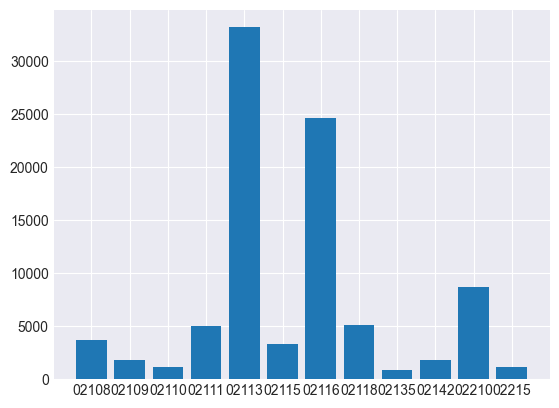

In [368]:
# Relationship Analysis
glue = df_b[["stars","postal_code","review_count"]].copy()
c = glue.groupby("postal_code",as_index=False).agg({'stars':'mean','review_count':'sum'})

# Create bars
plt.bar(c['postal_code'], c['review_count'])

# Show graphic
plt.show()


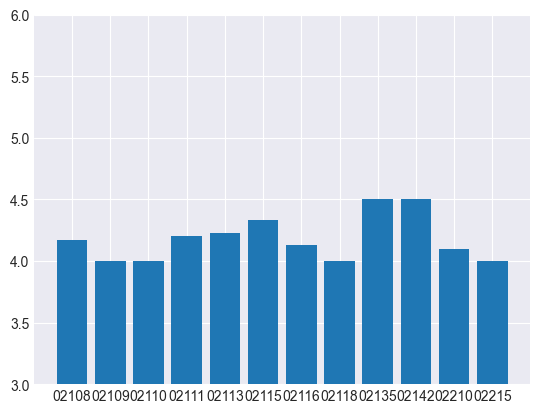

In [369]:
# Create bars
plt.bar(c['postal_code'], c['stars'])
plt.ylim([3,6])


# Show graphic
plt.show()

<AxesSubplot: xlabel='stars', ylabel='review_count'>

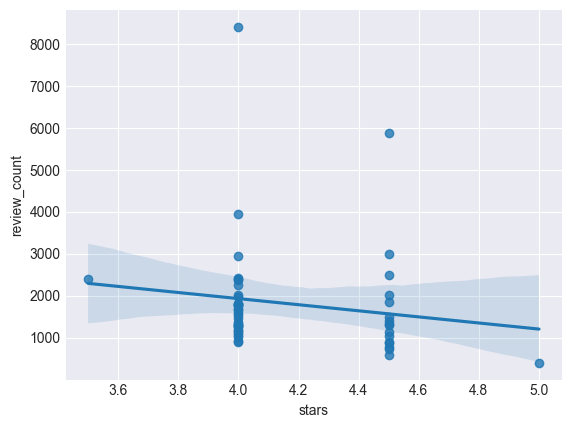

In [370]:
sns.regplot(y=glue["review_count"], x=glue["stars"])

In [371]:
#connect to mysql servel
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="Parvashah@123",
  database="yelpdb"
)

print(mydb)

mycursor = mydb.cursor()

# Insert the dataframe in to sql database

constring = 'mysql+mysqlconnector://root:%s@localhost:3306/yelpdb' % quote('Parvashah@123')
dbEngine = sqlalchemy.create_engine(constring, connect_args={'connect_timeout': 10}, echo=False)
try:
    with dbEngine.connect() as con:
        con.execute("SELECT 1")
    print('engine is valid')
except Exception as e:
    print(f'Engine invalid: {str(e)}')

engine is valid


In [372]:
# Insert data into business table from json file
df_b.to_sql(con=dbEngine, schema="yelpdb", name="temporary_table", if_exists="replace", index=False, chunksize=1000)
with dbEngine.begin() as cnx:
    insert_sql = 'INSERT IGNORE INTO business (SELECT * FROM temporary_table)'
    cnx.execute(insert_sql)

In [373]:
# Insert data into business table from json file
df_user.to_sql(con=dbEngine, schema="yelpdb", name="temporary_table", if_exists="replace", index=False, chunksize=1000)
with dbEngine.begin() as cnx:
    insert_sql = 'INSERT IGNORE INTO user (SELECT * FROM temporary_table)'
    cnx.execute(insert_sql)


In [374]:
# Insert data into business table from json file
df_cat.to_sql(con=dbEngine, schema="yelpdb", name="temporary_table", if_exists="replace", index=False, chunksize=1000)
with dbEngine.begin() as cnx:
    insert_sql = 'INSERT IGNORE INTO category (SELECT * FROM temporary_table)'
    cnx.execute(insert_sql)

In [375]:
# Insert data into review table from json file
df_review.to_sql(con=dbEngine, schema="yelpdb", name="temporary_table", if_exists="replace", index=False, chunksize=10000)
with dbEngine.begin() as cnx:
    insert_sql = 'INSERT IGNORE INTO review (SELECT * FROM temporary_table)'
    cnx.execute(insert_sql)